<a href="https://colab.research.google.com/github/as9786/ComputerVision/blob/main/ImageSegmentation/code/deeplabv3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depthwise Separable Convolution

## Depthwise Separable Convolution

In [41]:
import torch
import torch.nn as nn
from torchsummary import summary

In [42]:
class StandardConv(nn.Module):
  def __init__(self,channel,node):
    super().__init__()
    self.conv = nn.Conv2d(channel,node,kernel_size=3,padding=1)

  def forward(self,x):
    out = self.conv(x)
    return out

In [50]:
standard_conv = StandardConv(3,15)

In [51]:
summary(standard_conv,input_size=(3,8,8),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 15, 8, 8]             420
Total params: 420
Trainable params: 420
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [52]:
class DepthwiseConv(nn.Module):
    def __init__(self, channel, node):
        super(DepthwiseConv, self).__init__()
        self.depthwise = nn.Conv2d(channel, node, kernel_size=3, padding=1, groups=channel)


    def forward(self, x):
        out = self.depthwise(x)
        return out

In [55]:
class PointwiseConv(nn.Module):
    def __init__(self, channel, node):
        super().__init__()
        self.pointwise = nn.Conv2d(channel, node, kernel_size=1)

    def forward(self, x):
        out = self.pointwise(x)
        return out

In [64]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, nin,nout):
        super().__init__()
        self.depthwise = nn.Conv2d(nin, 3, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(3, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [65]:
dsc = DepthwiseSeparableConv(3,15)

In [66]:
summary(dsc,input_size=(3,8,8),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 3, 8, 8]              30
            Conv2d-2             [-1, 15, 8, 8]              60
Total params: 90
Trainable params: 90
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


# Deeplabv3

## Module

In [1]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.6 MB/s eta 0:00:00


In [2]:
import random
import os

from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt  
from torchsummary import summary as model_summary
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms as transform
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F

import monai
from monai.config import print_config

import time

## Seed setting

In [3]:
def seed_everything(seed=73):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything()

In [5]:
IS_DEBUG = False

## 장치

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

In [7]:
root_path = '/content/drive/MyDrive/seg'
model_save_path = './FCN_v2.pth'
CXR_path = os.path.join(root_path, 'CXR_png')
MASK_path = os.path.join(root_path, 'masks')
     

In [8]:
CXR_list = sorted(os.listdir(CXR_path))
MASK_list = sorted(os.listdir(MASK_path))

# mask name
MASK_list_ = list(map(lambda x:x.split('.')[0][:-5]+'.png', MASK_list))
# 공통적인 data 찾기
CXR_MASK_union_list = set(MASK_list_) & set(CXR_list)

CXR_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'CXR_png', x), CXR_MASK_union_list)))
MASK_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'masks', x.split('.')[0]+'_mask.png'), CXR_MASK_union_list)))

print(len(CXR_path_list), CXR_path_list[:1])
print(len(MASK_path_list), MASK_path_list[:1])
     

566 ['/content/drive/MyDrive/seg/CXR_png/CHNCXR_0001_0.png']
566 ['/content/drive/MyDrive/seg/masks/CHNCXR_0001_0_mask.png']


### Holdout

In [9]:
X, X_test, y, y_test = train_test_split(CXR_path_list, MASK_path_list, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
print(len(X_train), len(X_val), len(X_test))

samplex = torchvision.io.read_image(X_train[0])
sampley = torchvision.io.read_image(y_train[0])
print(samplex.shape, samplex.dtype)
print(sampley.shape, sampley.dtype, np.unique(sampley))

356 40 170
torch.Size([1, 2919, 3000]) torch.uint8
torch.Size([1, 2919, 3000]) torch.uint8 [  0 255]


In [10]:
class LungDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transforms_x):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.transforms_x = transforms_x

    assert len(img_dir) == len(mask_dir)

  def __len__(self):
    return len(self.img_dir)
  
  def __getitem__(self,idx):
    X = Image.open(self.img_dir[idx]).convert('RGB')
    X = X.resize((224,224))

    y = Image.open(self.mask_dir[idx])
    y = y.resize((224,224),Image.NEAREST)
    y = np.array(y)
    y = torch.from_numpy(y)
    y[y==255] = 1
    y_one_hot = F.one_hot(y.to(torch.int64))
    y_one_hot = y_one_hot.permute(2,0,1).to(torch.float)

    if self.transforms_x:
      X = self.transforms_x(X)

    instance = {'image':X,'mask':y_one_hot}
    return instance

In [11]:
transforms_x  = transform.Compose([
    transform.ToTensor()
])

In [12]:
train_data = LungDataset(X_train,y_train,transforms_x=transforms_x)
valid_data = LungDataset(X_val,y_val,transforms_x=transforms_x)
test_data = LungDataset(X_test,y_test,transforms_x=transforms_x)

In [13]:
train_loader = DataLoader(train_data,batch_size=4,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=1)
test_loader = DataLoader(test_data,batch_size=1)

In [14]:
x = next(iter(train_loader))
print('train_sample_x.shape: {}'.format(x['image'].shape))
print('train_sample_y.shape: {}'.format(x['mask'].shape))

train_sample_x.shape: torch.Size([4, 3, 224, 224])
train_sample_y.shape: torch.Size([4, 2, 224, 224])


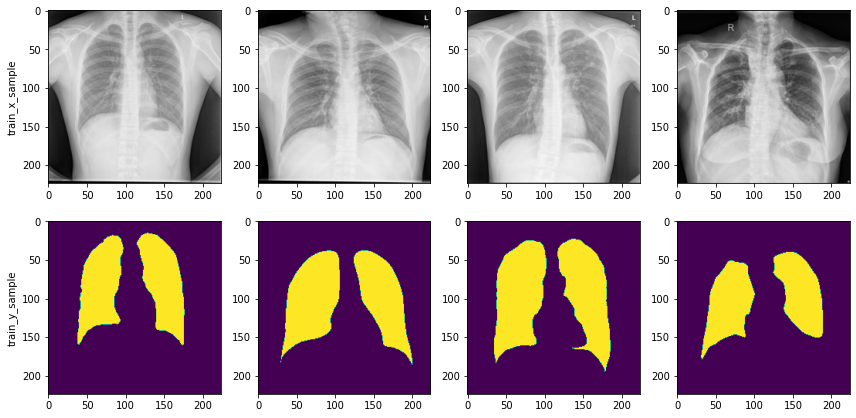

In [15]:
# 시각화
ncols, nrows = 4, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    img0 = x['image'][i].permute(1,2,0)
    img1 = x['mask'][i].permute(1,2,0)[:,:,-1]
    
    axes[0,i].imshow(img0)
    axes[0,0].set_ylabel('train_x_sample')
    
    axes[1,i].imshow(img1)
    axes[1,0].set_ylabel('train_y_sample')
plt.tight_layout()
plt.show()

## 모형

In [16]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [17]:
import segmentation_models_pytorch as smp

In [19]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 2
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [20]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [21]:
model.to(device)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=2e-4)
ce_loss = torch.nn.CrossEntropyLoss()
dice_loss = monai.metrics.DiceMetric(include_background=False,reduction='mean') # 배경에 관해서는 계산 x

## 학습

In [27]:
def train(model, train_loader, optimizer):
  since = time.time()
  model.train()
  epoch_loss = 0

  for batch, sample in enumerate(train_loader):
    X = sample['image']
    y = sample['mask']
    step = batch + 1
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    output = output
    loss = ce_loss(output, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    dice_output = torch.where(output>=0.5,1,0)
    dice_loss(y_pred=dice_output,y=y)

  epoch_loss /= step
  dice_score = dice_loss.aggregate().item()
  dice_loss.reset()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  return epoch_loss, dice_score

In [28]:
def evaluate(model, test_loader):
  model.eval()
  loss = 0
  with torch.no_grad():
    for batch, sample in enumerate(test_loader):
      X = sample['image']
      y = sample['mask']
      step = batch + 1
      X,y = X.to(device), y.to(device)
      output = model(X)
      output = output

      loss += ce_loss(output,y).item()
      dice_output = torch.where(output>=0.5,1,0)
      dice_loss(y_pred=dice_output,y=y)

    loss /= len(test_loader)
    dice_score = dice_loss.aggregate().item()
    dice_loss.reset()

    return loss, dice_score

In [29]:
losses = {'train':[],'val':[]}
dice_scores = {'train':[],'val':[]}
best_metric, best_epoch = 999,-1

for epoch in range(1,11):
  train_loss, train_dice_score = train(model, train_loader, optimizer) 
  val_loss, val_dice_score = evaluate(model,valid_loader)

  losses['train'].append(train_loss)
  losses['val'].append(val_loss)
  dice_scores['train'].append(train_dice_score)
  dice_scores['val'].append(val_dice_score)

  print(f'[{epoch}] Train Loss: {train_loss:.6f}, Dice score: {train_dice_score:.6f}')
  print(f'[{epoch}] Test Loss: {val_loss:.6f}, Dice score: {val_dice_score:.6f}')

  if losses['val'][-1] < best_metric:
    best_metric = losses['val'][-1]
    best_epoch = epoch
    torch.save(model.state_dict(),model_save_path)
    print('Save model')

Training complete in 5m 30s
[1] Train Loss: 0.372976, Dice score: 0.923833
[1] Test Loss: 0.384922, Dice score: 0.872596
Save model
Training complete in 1m 21s
[2] Train Loss: 0.338751, Dice score: 0.952835
[2] Test Loss: 0.354534, Dice score: 0.909221
Save model
Training complete in 1m 23s
[3] Train Loss: 0.335942, Dice score: 0.956352
[3] Test Loss: 0.375995, Dice score: 0.888295
Training complete in 1m 20s
[4] Train Loss: 0.334643, Dice score: 0.957991
[4] Test Loss: 0.516341, Dice score: 0.670217
Training complete in 1m 22s
[5] Train Loss: 0.334940, Dice score: 0.957044
[5] Test Loss: 0.336805, Dice score: 0.949628
Save model
Training complete in 1m 20s
[6] Train Loss: 0.334632, Dice score: 0.957439
[6] Test Loss: 0.409374, Dice score: 0.799267
Training complete in 1m 21s
[7] Train Loss: 0.334889, Dice score: 0.957122
[7] Test Loss: 0.403293, Dice score: 0.716527
Training complete in 1m 22s
[8] Train Loss: 0.334570, Dice score: 0.957482
[8] Test Loss: 0.586039, Dice score: 0.594877

In [30]:
print(f"train completed, best_metric: {best_metric:.4f} \n" 
      f"at epoch: {best_epoch}")

train completed, best_metric: 0.3351 
at epoch: 9


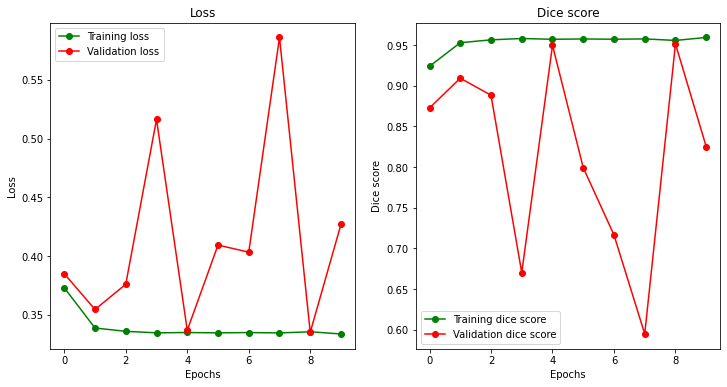

In [31]:
epochs = [i for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].plot(epochs,train_loss,'g-o',label='Training loss')
ax[0].plot(epochs,val_loss,'r-o',label='Validation loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs,train_dice,'go-',label='Training dice score')
ax[1].plot(epochs,val_dice,'ro-',label='Validation dice score')
ax[1].set_title('Dice score')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Dice score')
plt.show()

In [33]:
len_test = len(test_loader)

pred_dict = {'input':[],'target':[],'output':[]}

model.load_state_dict(torch.load(model_save_path))  
model.to('cpu')
model.eval()

with torch.no_grad():
  for i, sample in enumerate(test_loader):
    X = sample['image']
    y = sample['mask']
    output = model(X)
    output = output
    output = torch.argmax(output,dim=1,keepdim=True)

    data = X[0].permute(1,2,0)
    target = y[0].permute(1,2,0)[:,:,-1]
    output_ = output[0].permute(1,2,0)[:,:,-1]

    pred_dict['input'].append(data)
    pred_dict['target'].append(target)
    pred_dict['output'].append(output_)

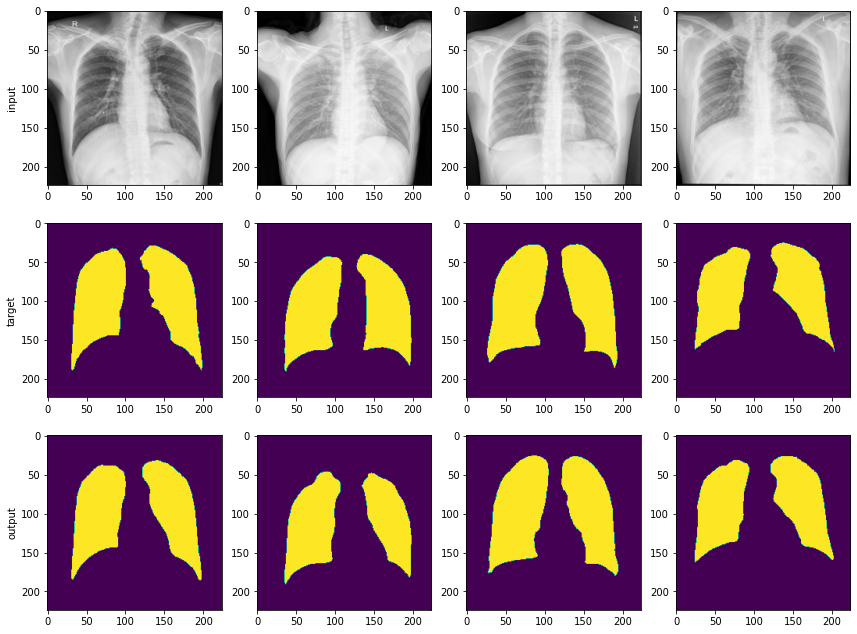

In [34]:
ncols, nrows = 4, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    axes[0,i].imshow(pred_dict['input'][i])
    axes[0,0].set_ylabel('input')

    axes[1,i].imshow(pred_dict['target'][i])
    axes[1,0].set_ylabel('target')

    axes[2,i].imshow(pred_dict['output'][i])
    axes[2,0].set_ylabel('output')

plt.tight_layout()
plt.show()